## EDA: Temporal Analysis of Late Returns in Library Borrowings

This notebook explores patterns in late returns based on the borrowing date.
We analyze:

- The relationship between **weekday** and late returns.
- The relationship between **month** and late returns.
- The library closure days.

The goal is to identify temporal trends that might influence the likelihood of returning books late.


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from utils import setup_pandas, setup_plotting

# --- global notebook setup (pandas + tueplots/matplotlib style) ---
setup_pandas()
setup_plotting()

# --- project paths ---
PROCESSED_DATA_PATH = Path('../dat/processed')
CLEANED_FILE = PROCESSED_DATA_PATH / "borrowings_2019_2025_cleaned.csv"

# --- load data ---
df = pd.read_csv(
    CLEANED_FILE,
    sep=";",
    quotechar='"',
    encoding="utf-8"
)
df['Ausleihdatum/Uhrzeit'] = pd.to_datetime(df['Ausleihdatum/Uhrzeit'])
df['Rückgabedatum/Uhrzeit'] = pd.to_datetime(df['Rückgabedatum/Uhrzeit'])
print("Loaded shape:", df.shape)


Loaded shape: (2313072, 21)


### Analysis of the weekday of borrowing and late returns

In [6]:
global_late_rate = (df["Verspätet"] == "Ja").mean()

df["checkout_wd"] = df["Ausleihdatum/Uhrzeit"].dt.day_name()

weekday_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

# group by weekday and calculate late return rate
weekly_overview = (
    df[df["checkout_wd"] != "Sunday"]  # filter sunday out
    .assign(late = (df["Verspätet"] == "Ja"))
    .groupby("checkout_wd")
    .agg(
        n_loans=("checkout_wd", "size"),
        late_rate=("late", "mean"),
        avg_extensions=("Anzahl_Verlängerungen", "mean")
    )
    .reindex(weekday_order)
    .dropna()
    .reset_index()
)

print(weekly_overview)
print(f"The general average for late returns is: {global_late_rate:.2%}")

  checkout_wd      n_loans  late_rate  avg_extensions
0      Monday  63,585.0000     0.0417          0.9402
1     Tuesday 518,743.0000     0.0399          1.2678
2   Wednesday 437,506.0000     0.0428          1.3356
3    Thursday 414,257.0000     0.0450          1.3219
4      Friday 446,210.0000     0.0433          1.3726
5    Saturday 432,592.0000     0.0381          1.4133
The general average for late returns is: 4.17%


late_rate : $P(\text{late return} \mid \text{loan day})$

Interpretation: „Given that a book is borrowed on day X, what is the probability that it will be returned late?“

/var/folders/zr/spgxm1td597dgv39lljd_8tr0000gn/T/ipykernel_15212/3545871847.py:35: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


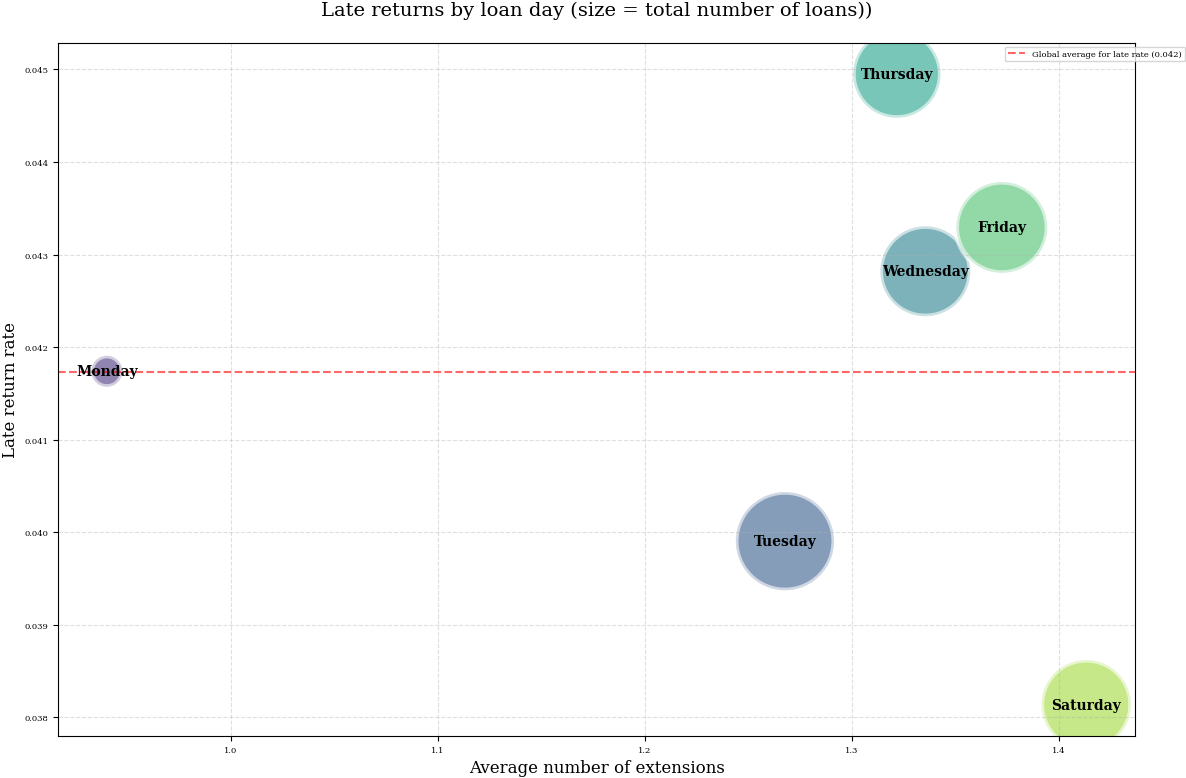

In [7]:
plt.figure(figsize=(12, 8))


bubble = sns.scatterplot(
    data=weekly_overview,
    x="avg_extensions",
    y="late_rate",
    size="n_loans",
    hue="checkout_wd",
    sizes=(500, 5000),
    alpha=0.6,
    palette="viridis"
)

# reference line for global late rate
line = plt.axhline(global_late_rate, color='red', linestyle='--', alpha=0.6, label=f"Global average for late rate ({global_late_rate:.3f})")

for i in range(weekly_overview.shape[0]):
    plt.text(
        weekly_overview.avg_extensions[i],
        weekly_overview.late_rate[i],
        weekly_overview.checkout_wd[i],
        fontsize=10, fontweight='bold', ha='center', va='center'
    )

plt.legend(handles=[line], labels=[line.get_label()],
           bbox_to_anchor=(1.05, 1))

plt.title("Late returns by loan day (size = total number of loans))", fontsize=14, pad=20)
plt.xlabel("Average number of extensions", fontsize=12)
plt.ylabel("Late return rate", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.4)


plt.tight_layout()
plt.show()

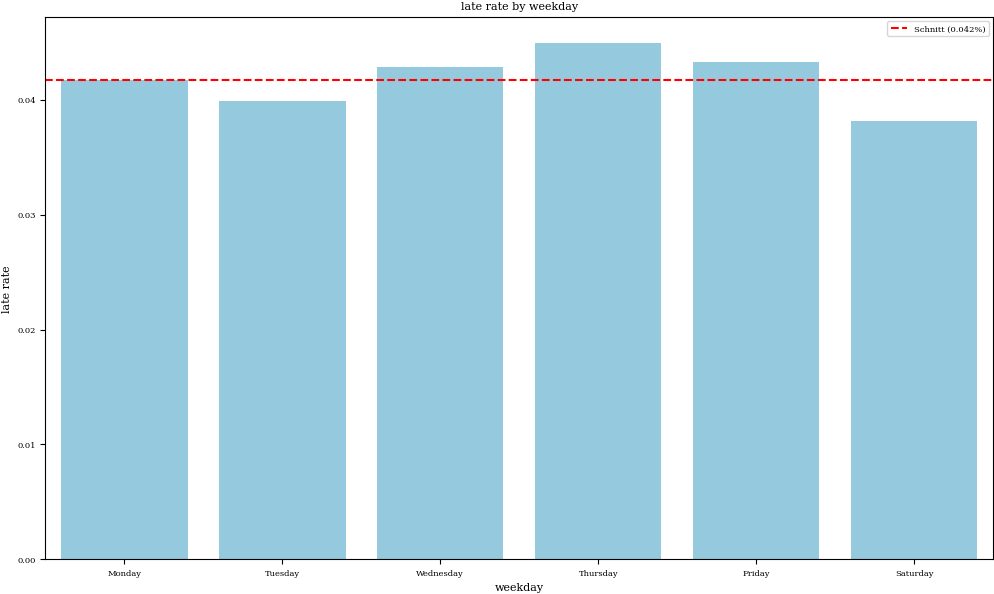

In [8]:
plt.figure(figsize=(10, 6))
sns.barplot(data=weekly_overview, x="checkout_wd", y="late_rate", color="skyblue")


plt.axhline(global_late_rate, color='red', linestyle='--', label=f"Schnitt ({global_late_rate:.3f}%)")
plt.title("late rate by weekday")
plt.ylabel("late rate")
plt.xlabel("weekday")
plt.legend()
plt.show()

### Analysis of late rate by month

In [9]:
df["checkout_month"] = df["Ausleihdatum/Uhrzeit"].dt.month_name()

month_order = [
    "January", "February", "March", "April", "May", "June",
    "July", "August", "September", "October", "November", "December"
]

monthly_overview = (
    df.assign(late = (df["Verspätet"] == "Ja"))
    .groupby("checkout_month")
    .agg(
        n_loans=("checkout_month", "size"),
        late_rate=("late", "mean"),
        avg_extensions=("Anzahl_Verlängerungen", "mean")
    )
    .reindex(month_order)
    .reset_index()
)

print(monthly_overview)
print(f"The general average for late returns is: {global_late_rate:.2%}")



   checkout_month  n_loans  late_rate  avg_extensions
0         January   179821     0.0435          1.4497
1        February   207174     0.0420          1.3161
2           March   204886     0.0419          1.2517
3           April   172711     0.0400          1.2829
4             May   190420     0.0399          1.2953
5            June   172943     0.0468          1.3881
6            July   244197     0.0418          1.3647
7          August   204374     0.0457          1.4242
8       September   189316     0.0419          1.3202
9         October   211800     0.0422          1.3468
10       November   189890     0.0391          1.3004
11       December   145540     0.0344          1.1607
The general average for late returns is: 4.17%


/var/folders/zr/spgxm1td597dgv39lljd_8tr0000gn/T/ipykernel_15212/2066906057.py:14: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


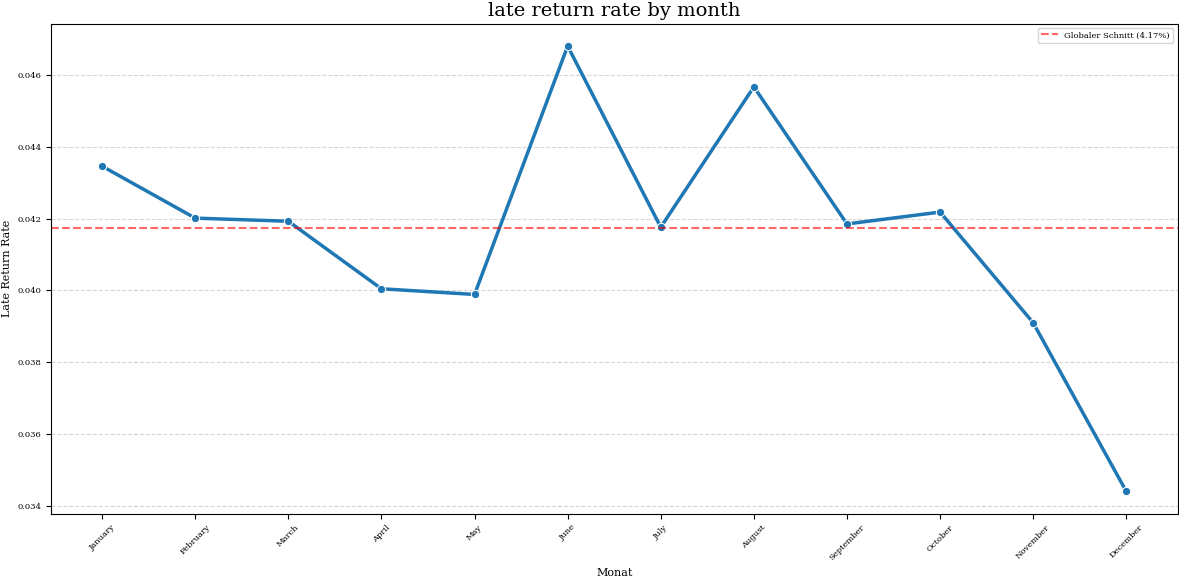

In [10]:
plt.figure(figsize=(12, 6))

sns.lineplot(data=monthly_overview, x="checkout_month", y="late_rate", marker="o", linewidth=2.5, color="#1f77b4")

plt.axhline(global_late_rate, color='red', linestyle='--', alpha=0.6, label=f"Globaler Schnitt ({global_late_rate:.2%})")

plt.title("late return rate by month", fontsize=14)
plt.ylabel("Late Return Rate")
plt.xlabel("Monat")
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.legend()
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

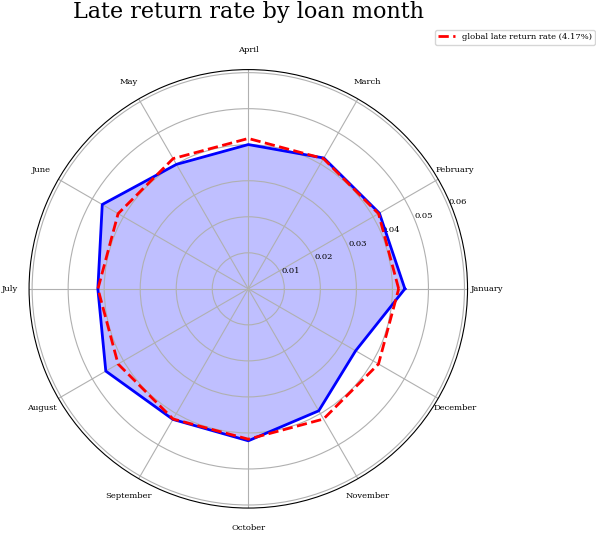

In [11]:
labels = monthly_overview['checkout_month'].values
stats = monthly_overview['late_rate'].values

stats = np.concatenate((stats, [stats[0]]))
labels = np.concatenate((labels, [labels[0]]))

angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=True)

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

ax.fill(angles, stats, color='blue', alpha=0.25)
ax.plot(angles, stats, color='blue', linewidth=2)

# baseline global average(4.41%)
global_line = [global_late_rate] * len(angles)
ax.plot(angles, global_line, color='red', linestyle='--', linewidth=2, label=f"global late return rate ({global_late_rate:.2%})")

ax.set_thetagrids(angles[:-1] * 180/np.pi, monthly_overview['checkout_month'])

ax.set_ylim(0, max(stats) * 1.3)

plt.title("Late return rate by loan month", size=16, pad=20)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

plt.show()

/var/folders/zr/spgxm1td597dgv39lljd_8tr0000gn/T/ipykernel_15212/4019751811.py:31: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


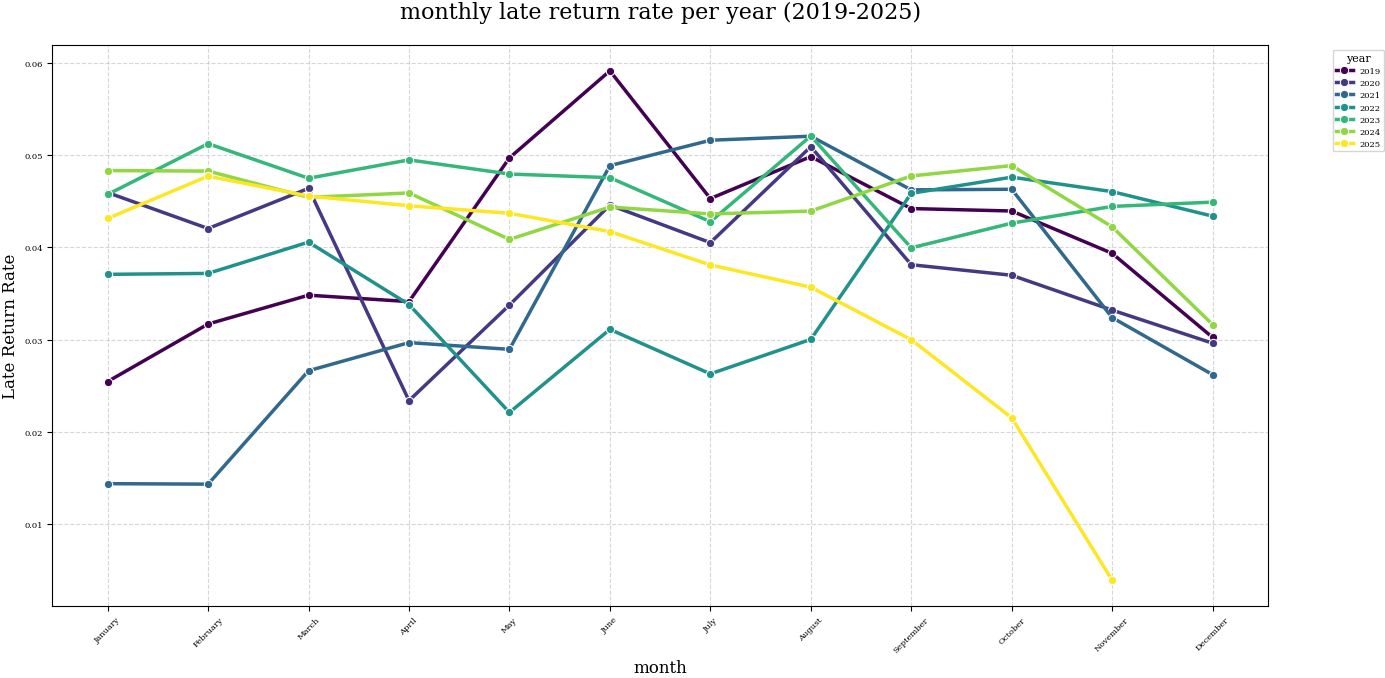

In [12]:

df["year"] = df["Ausleihdatum/Uhrzeit"].dt.year
df["month"] = df["Ausleihdatum/Uhrzeit"].dt.month_name()

yearly_trends = (
    df.assign(late = (df["Verspätet"] == "Ja"))
    .groupby(["year", "month"])
    .agg(late_rate=("late", "mean"))
    .reset_index()
)
yearly_trends["month"] = pd.Categorical(yearly_trends["month"], categories=month_order, ordered=True)
plt.figure(figsize=(14, 7))

sns.lineplot(
    data=yearly_trends,
    x="month",
    y="late_rate",
    hue="year",
    marker="o",
    palette="viridis",
    linewidth=2.5
)

plt.title("monthly late return rate per year (2019-2025)", fontsize=16, pad=20)
plt.ylabel("Late Return Rate", fontsize=12)
plt.xlabel("month", fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)

plt.legend(title="year", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

### Library closing days

In [15]:
df_schliess = pd.read_csv("../dat/raw/closed_days.csv", sep=";")

df_schliess = df_schliess[
    (df_schliess['Zweigstelle'] == 'HST') # &
    #(~df_schliess['Anlass'].str.contains('corona', case=False, na=False))
]
df_schliess = df_schliess.reset_index(drop=True)
len(df_schliess)

412

In [16]:
df_schliess['schliesstag'] = pd.to_datetime(df_schliess['schliesstag'], dayfirst=True)

df_schliess = df_schliess.sort_values('schliesstag')


group_id = (df_schliess['schliesstag'].diff() != pd.Timedelta(days=1)).cumsum()

df_zeitspannen = df_schliess.groupby(group_id).agg(
    Startdatum=('schliesstag', 'min'),
    Enddatum=('schliesstag', 'max'),
    Anlass=('Anlass', 'first'),
    Anzahl_Tage=('schliesstag', 'count')
)

df_zeitspannen = df_zeitspannen.reset_index(drop=True)

print(df_zeitspannen)

    Startdatum   Enddatum               Anlass  Anzahl_Tage
0   2019-01-02 2019-01-05     Umstieg LMS-koha            4
1   2019-01-07 2019-01-12     Umstieg LMS-koha            6
2   2019-01-14 2019-01-19     Umstieg LMS-koha            6
3   2019-01-21 2019-01-26     Umstieg LMS-koha            6
4   2019-01-28 2019-02-02     Umstieg LMS-koha            6
..         ...        ...                  ...          ...
107 2025-05-29 2025-05-29  Christi Himmelfahrt            1
108 2025-12-23 2025-12-23                 None            1
109 2025-12-27 2025-12-27                 None            1
110 2025-12-30 2025-12-31                 None            2
111 2026-01-02 2026-01-03                 None            2

[112 rows x 4 columns]


/var/folders/zr/spgxm1td597dgv39lljd_8tr0000gn/T/ipykernel_15212/52034825.py:45: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


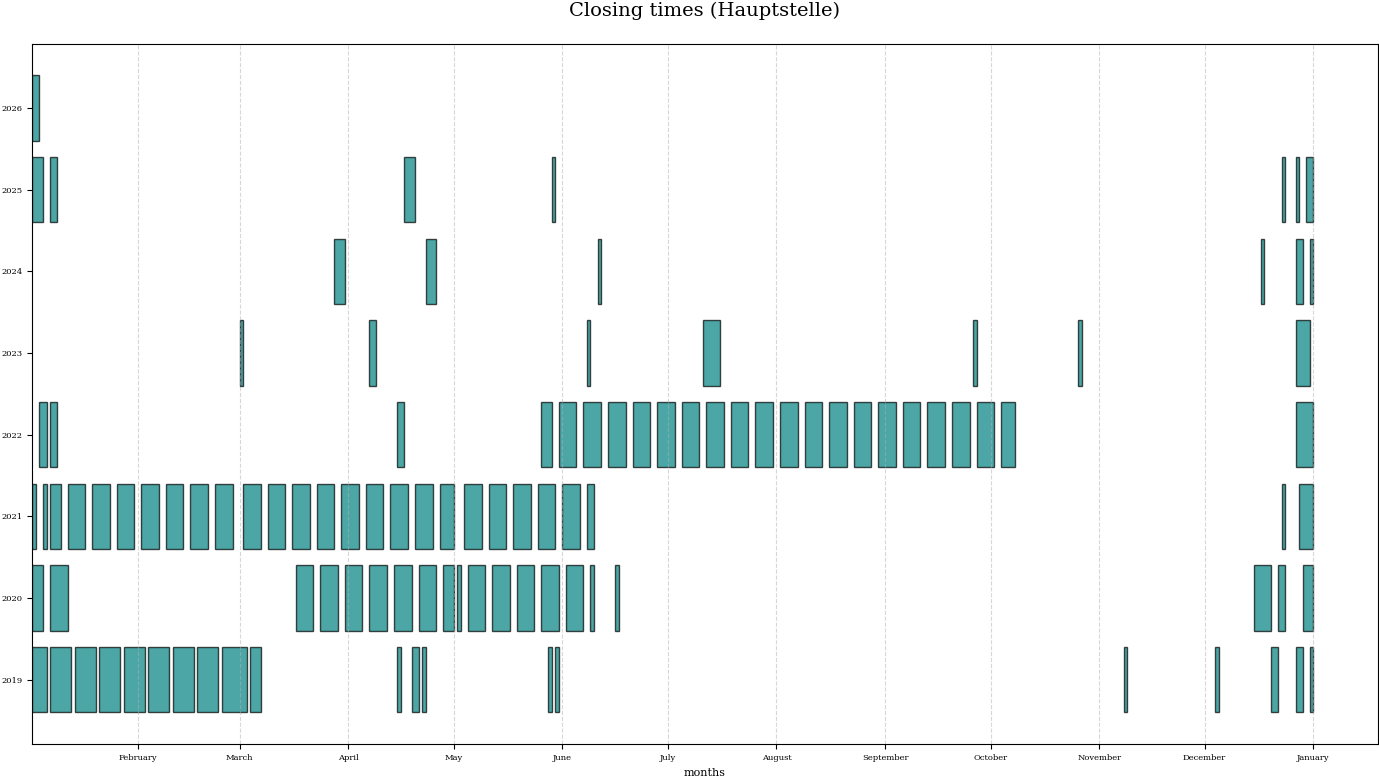

In [17]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

df_schliess['schliesstag'] = pd.to_datetime(df_schliess['schliesstag'], dayfirst=True)
df_schliess = df_schliess.sort_values('schliesstag')

group_id = (
    (df_schliess['schliesstag'].diff() != pd.Timedelta(days=1)) |
    (df_schliess['Zweigstelle'] != df_schliess['Zweigstelle'].shift())
).cumsum()

df_phasen = df_schliess.groupby(group_id).agg(
    Startdatum=('schliesstag', 'min'),
    Enddatum=('schliesstag', 'max'),
    Anlass=('Anlass', 'first'),
    Anzahl_Tage=('schliesstag', 'count'),
    Jahr=('schliesstag', lambda x: x.dt.year.iloc[0])
).reset_index(drop=True)


years = sorted(df_phasen['Jahr'].unique(), reverse=True)
plt.figure(figsize=(14, 8))

for i, year in enumerate(years):
    year_data = df_phasen[df_phasen['Jahr'] == year]

    for _, row in year_data.iterrows():
        start_plot = row['Startdatum'].replace(year=2024)
        ende_plot = row['Enddatum'].replace(year=2024)

        plt.barh(y=year, width=(ende_plot - start_plot + pd.Timedelta(days=1)),
                 left=start_plot, color='teal', edgecolor='black', alpha=0.7)

plt.title('Closing times (Hauptstelle)', fontsize=14, pad=20)
ax = plt.gca()

ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%B'))

plt.yticks(years)
plt.xlabel('months')
plt.grid(axis='x', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

In [19]:
mean_leihdauer_pro_monat = (
    df.groupby("month", as_index=False)["Leihdauer"]
      .mean()
)
print(mean_leihdauer_pro_monat)

        month  Leihdauer
0       April    50.6718
1      August    45.7313
2    December    58.8608
3    February    52.7807
4     January    50.0921
5        July    50.0286
6        June    45.1073
7       March    54.4766
8         May    50.6796
9    November    52.4671
10    October    48.9549
11  September    45.8534
